In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re  # For regular expressions and text cleaning
import string  # For string operations like punctuation removal
from collections import Counter  # For counting word frequencies
from sklearn.feature_extraction.text import CountVectorizer  # For converting text to a bag-of-words model
from wordcloud import WordCloud  # For visualization of frequent words

In [ ]:
# Set the style for plots
plt.style.use('ggplot')  # Use 'ggplot' style for matplotlib plots
sns.set(font_scale=1.2)  # Increase the font scale for Seaborn plots
sns.set_style("whitegrid")  # Set Seaborn plot style to 'whitegrid'

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# 1. Data Loading and Initial Inspection
# --------------------------------------
# Load the data
df = pd.read_csv('cleaned_customer_say_reviews.csv')

# Display basic info
print("\n=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())


=== Dataset Overview ===
Shape: (223, 10)

First few rows:
                                               Name   Price  Count  \
0  Colgate Visible White Purple Toothpaste For Te...    278     59   
1  Colgate Visible White Purple Toothpaste For Te...    278     46   
2  Colgate Visible White Purple Toothpaste For Te...    278     33   
3  Colgate Visible White Purple Toothpaste For Te...    278     24   
4  Colgate Visible White Purple Toothpaste For Te...    278     17   

   Positive Review  Negative Review  \
0               51                8   
1               35               11   
2               24                9   
3               24                0   
4               17                0   

                                Detailed Review Text  \
0   Customers like the whitening effect of the to...   
1   Customers appreciate the quality of the tooth...   
2   Customers like the toothpaste's effectiveness...   
3   Customers like the color of the tooth cleanin...   
4   

In [ ]:
print("\nColumn names:")
print(df.columns.tolist())

print("\nData types:")
print(df.dtypes)

print("\nCheck for missing values:")
print(df.isnull().sum())


Column names:
['Name ', 'Price', 'Count', 'Positive Review', 'Negative Review', 'Detailed Review Text', 'Review 2', 'Review 3', 'Review 4', 'Key Features ']

Data types:
Name                    object
Price                    int64
Count                    int64
Positive Review          int64
Negative Review          int64
Detailed Review Text    object
Review 2                object
Review 3                object
Review 4                object
Key Features            object
dtype: object

Check for missing values:
Name                    0
Price                   0
Count                   0
Positive Review         0
Negative Review         0
Detailed Review Text    0
Review 2                0
Review 3                0
Review 4                9
Key Features            0
dtype: int64


In [ ]:
# 2. Data Preprocessing
# --------------------
# Clean column names (remove spaces, standardize)

print("\n=== Cleaning Column Names ===")
df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]
print("Cleaned column names:", df.columns.tolist())
#if a column was named " Customer Name ", it becomes "customer_name".
#strip - Removes any leading or trailing spaces from the column name
#replace me hum " " ko "-" kr rhe


# Fix data types
# Convert price to numeric (remove non-numeric characters if any)
print("\n=== Converting Data Types ===")
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['count'] = pd.to_numeric(df['count'], errors='coerce')
df['positive_review'] = pd.to_numeric(df['positive_review'], errors='coerce')
df['negative_review'] = pd.to_numeric(df['negative_review'], errors='coerce')
#isme sirf numeric data type me change kr rhe, coerce mtlb if null values hai toh vo vaha NAN daal dega, and error throw nhi krega

print("After fixing data types:")
print(df.dtypes)


=== Cleaning Column Names ===
Cleaned column names: ['name', 'price', 'count', 'positive_review', 'negative_review', 'detailed_review_text', 'review_2', 'review_3', 'review_4', 'key_features']

=== Converting Data Types ===
After fixing data types:
name                    object
price                    int64
count                    int64
positive_review          int64
negative_review          int64
detailed_review_text    object
review_2                object
review_3                object
review_4                object
key_features            object
dtype: object


In [ ]:
# Extract product names (shorter versions) for better visualization
print("\n=== Creating Short Product Names ===")

def extract_product_name(full_name):
    # If there's a comma, take the part before it as the main name
    if ',' in full_name:
        return full_name.split(',')[0].strip()
    else:
        # Otherwise, take the first 50 characters and add '...'
        return full_name[:50].strip() + '...'

# Apply the function to the 'name' column to create a new 'short_name' column
df['short_name'] = df['name'].apply(extract_product_name)

print("Sample of short names:")
print(df['short_name'].head())



=== Creating Short Product Names ===
Sample of short names:
0    Colgate Visible White Purple Toothpaste For Te...
1    Colgate Visible White Purple Toothpaste For Te...
2    Colgate Visible White Purple Toothpaste For Te...
3    Colgate Visible White Purple Toothpaste For Te...
4    Colgate Visible White Purple Toothpaste For Te...
Name: short_name, dtype: object


In [ ]:
# 3. Exploratory Data Analysis
# ---------------------------
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Basic statistics for numerical columns
print("\nStatistical Summary:")
print(df[['price', 'count', 'positive_review', 'negative_review']].describe())


=== EXPLORATORY DATA ANALYSIS ===

Statistical Summary:
            price       count  positive_review  negative_review
count  223.000000  223.000000       223.000000       223.000000
mean   232.210762   37.928251        32.766816         5.197309
std    108.906049   70.099249        64.780290        12.021999
min     80.000000    0.000000         0.000000         0.000000
25%    160.000000    7.000000         7.000000         0.000000
50%    218.000000   16.000000        14.000000         0.000000
75%    278.000000   40.000000        34.000000         5.000000
max    569.000000  722.000000       688.000000       109.000000


In [ ]:
# Calculate sentiment ratio (positive to total reviews)
print("\n=== Calculating Sentiment Metrics ===")

# Calculate total reviews by summing positive and negative reviews
df['total_reviews'] = df['positive_review'] + df['negative_review']

# Calculate sentiment ratio = positive reviews divided by total reviews
df['sentiment_ratio'] = df['positive_review'] / df['total_reviews']

# Calculate sentiment score = (positive - negative) / total reviews
# This shows overall sentiment: positive score means more good reviews, negative means more bad
df['sentiment_score'] = (df['positive_review'] - df['negative_review']) / df['total_reviews']

# Show first few rows of the sentiment metrics along with product short names
print("\nSentiment metrics overview:")
print(df[['short_name', 'sentiment_ratio', 'sentiment_score']].head())


=== Calculating Sentiment Metrics ===

Sentiment metrics overview:
                                          short_name  sentiment_ratio  \
0  Colgate Visible White Purple Toothpaste For Te...         0.864407   
1  Colgate Visible White Purple Toothpaste For Te...         0.760870   
2  Colgate Visible White Purple Toothpaste For Te...         0.727273   
3  Colgate Visible White Purple Toothpaste For Te...         1.000000   
4  Colgate Visible White Purple Toothpaste For Te...         1.000000   

   sentiment_score  
0         0.728814  
1         0.521739  
2         0.454545  
3         1.000000  
4         1.000000  


In [ ]:
# Group by product type
print("\n=== Product Type Analysis ===")

# Define a function to extract the product type based on keywords in the name
def extract_product_type(name):
    # Check for specific known product types in order of priority
    if "Visible White Purple" in name:
        return "Visible White Purple"
    elif "Visible White O2" in name:
        return "Visible White O2"
    elif "Visible White" in name:
        return "Visible White"
    elif "Charcoal Clean" in name:
        return "Charcoal Clean"
    elif "Total Advanced Health" in name:
        return "Total Advanced Health"
    elif "Lemon Fresh" in name:
        return "Lemon Fresh"
    elif "MaxFresh" in name:
        return "MaxFresh"
    else:
        # If no known type is found, label it as "Other"
        return "Other"


=== Product Type Analysis ===


In [ ]:
# Apply the function to extract and assign product types to a new column
df['product_type'] = df['name'].apply(extract_product_type)

In [ ]:
# Group by product type and calculate average sentiment
product_sentiment = df.groupby('product_type').agg({
    'sentiment_ratio': 'mean',   # Average positive review ratio per product type
    'sentiment_score': 'mean',   # Average sentiment score per product type
    'price': 'mean',             # Average price per product type
    'count': 'sum'               # Total number of reviews per product type
}).reset_index()  # Convert groupby object back to a DataFrame

print("\nSentiment by product type:")
print(product_sentiment)


Sentiment by product type:
            product_type  sentiment_ratio  sentiment_score       price  count
0         Charcoal Clean         0.770018         0.540036  173.285714    369
1            Lemon Fresh         1.000000         1.000000  148.000000     51
2               MaxFresh         0.953201         0.906402  226.666667    309
3                  Other         0.903559         0.807118  229.800000   6654
4  Total Advanced Health         0.961982         0.923963  456.000000    171
5          Visible White         0.960788         0.921575  243.000000    120
6       Visible White O2         0.467601        -0.064797  176.000000    555
7   Visible White Purple         0.841863         0.683726  278.000000    229



=== CREATING VISUALIZATIONS ===


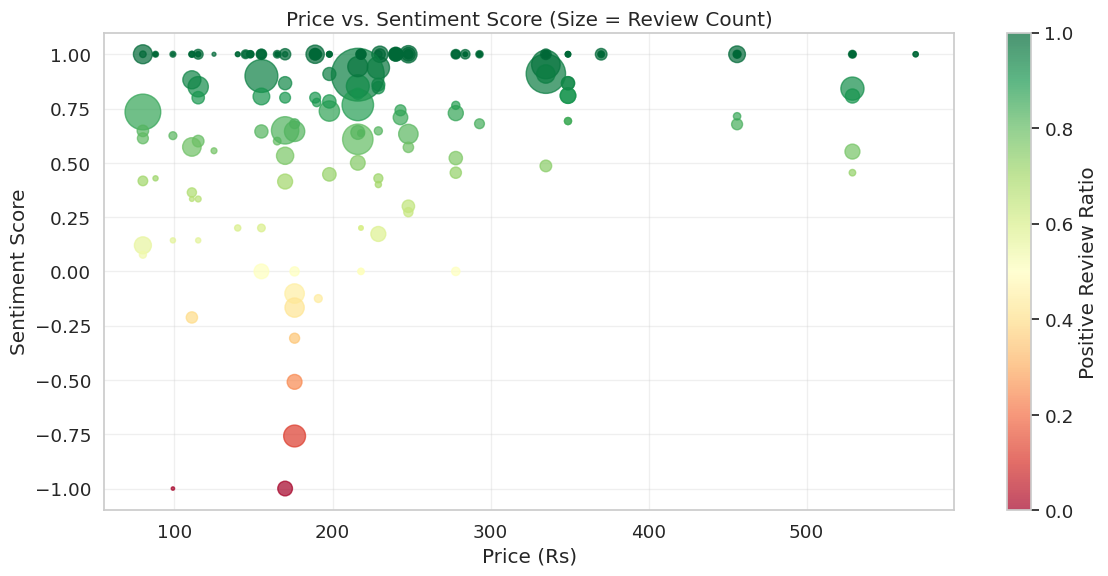

In [ ]:
# 4. Visualization
# ---------------
print("\n=== CREATING VISUALIZATIONS ===")

# Plot 1: Price vs. Sentiment Score
plt.figure(figsize=(12, 6))  # Set the size of the plot

# Create a scatter plot:
# X-axis = price, Y-axis = sentiment score
# Size of each point = number of reviews (count), color = sentiment ratio
plt.scatter(
    df['price'],
    df['sentiment_score'],
    alpha=0.7,  # Transparency for better visibility
    s=df['count']*2,  # Scale size of dots by review count
    c=df['sentiment_ratio'],  # Color by positive review ratio
    cmap='RdYlGn'  # Red (low) to Green (high) color map
)

plt.colorbar(label='Positive Review Ratio')  # Add color bar legend
plt.title('Price vs. Sentiment Score (Size = Review Count)')  # Title of the plot
plt.xlabel('Price (Rs)')  # Label for x-axis
plt.ylabel('Sentiment Score')  # Label for y-axis
plt.grid(True, alpha=0.3)  # Light grid for readability
plt.tight_layout()  # Adjust layout to fit elements neatly
plt.savefig('price_vs_sentiment.png')  # Save the plot as an image file
plt.show()  # Display the plot

In [ ]:
#This graph shows the relationship between the price of a product (on the x-axis) and its sentiment score (on the y-axis),
#where each data point represents a product. The size of the circles indicates the number of reviews a product has received—larger circles mean more reviews.
#Additionally, the color of the circles represents the positive review ratio, with green indicating a higher percentage of positive reviews and red indicating a lower percentage.
#The general trend shows that products with higher prices tend to have higher sentiment scores and more positive reviews, but there are some exceptions.
#The graph provides insights into how price might influence customer sentiment and review count for products.

<ipython-input-15-a9ae24f381fb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_type', y='sentiment_score', data=product_sentiment, palette='viridis')


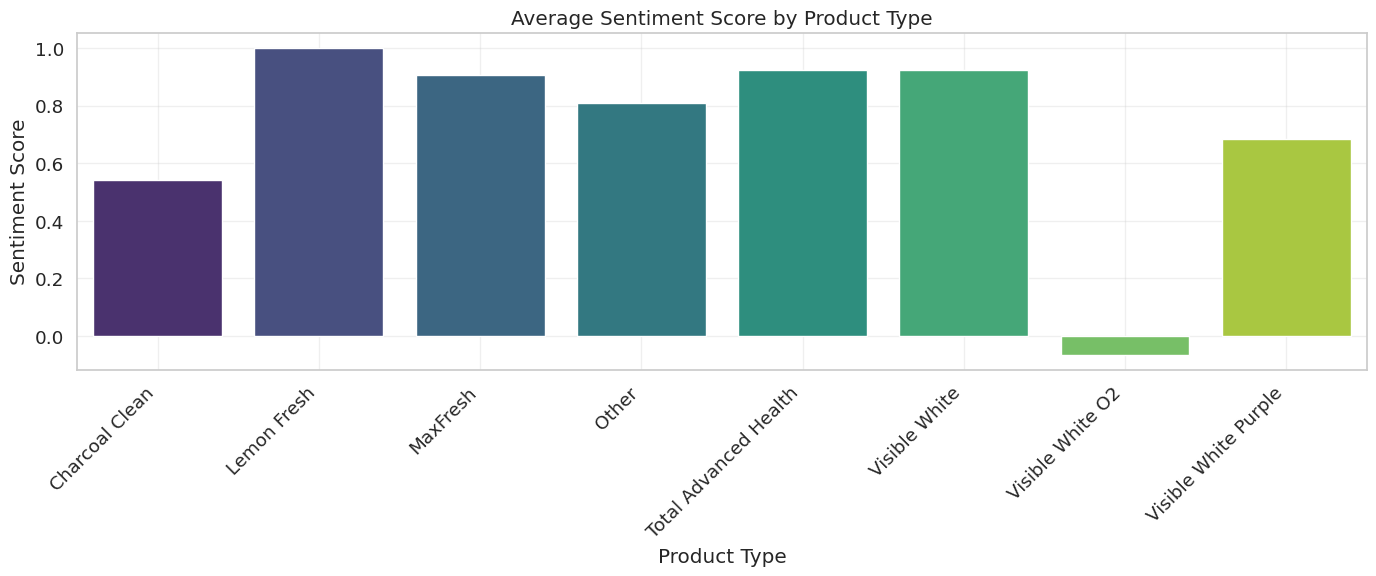

In [ ]:
# Plot 2: Product Type Comparison
plt.figure(figsize=(14, 6))
sns.barplot(x='product_type', y='sentiment_score', data=product_sentiment, palette='viridis')
plt.title('Average Sentiment Score by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('product_type_sentiment.png')
plt.show()

In [ ]:
#This graph shows the average sentiment scores for different types of products.
#The sentiment score is a measure of how positive or negative the feedback is, with 1 being the most positive.
#The graph has bars for each product type, showing how people generally feel about them. For example, "Lemon Fresh" has the highest score, close to 1,
#meaning people feel very positively about it. On the other hand, "Visible White O2" has a much lower score, indicating less positive feedback.
#The other product types fall in between these two extremes, showing varying levels of customer satisfaction.

<ipython-input-16-9d4d1d6824e5>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


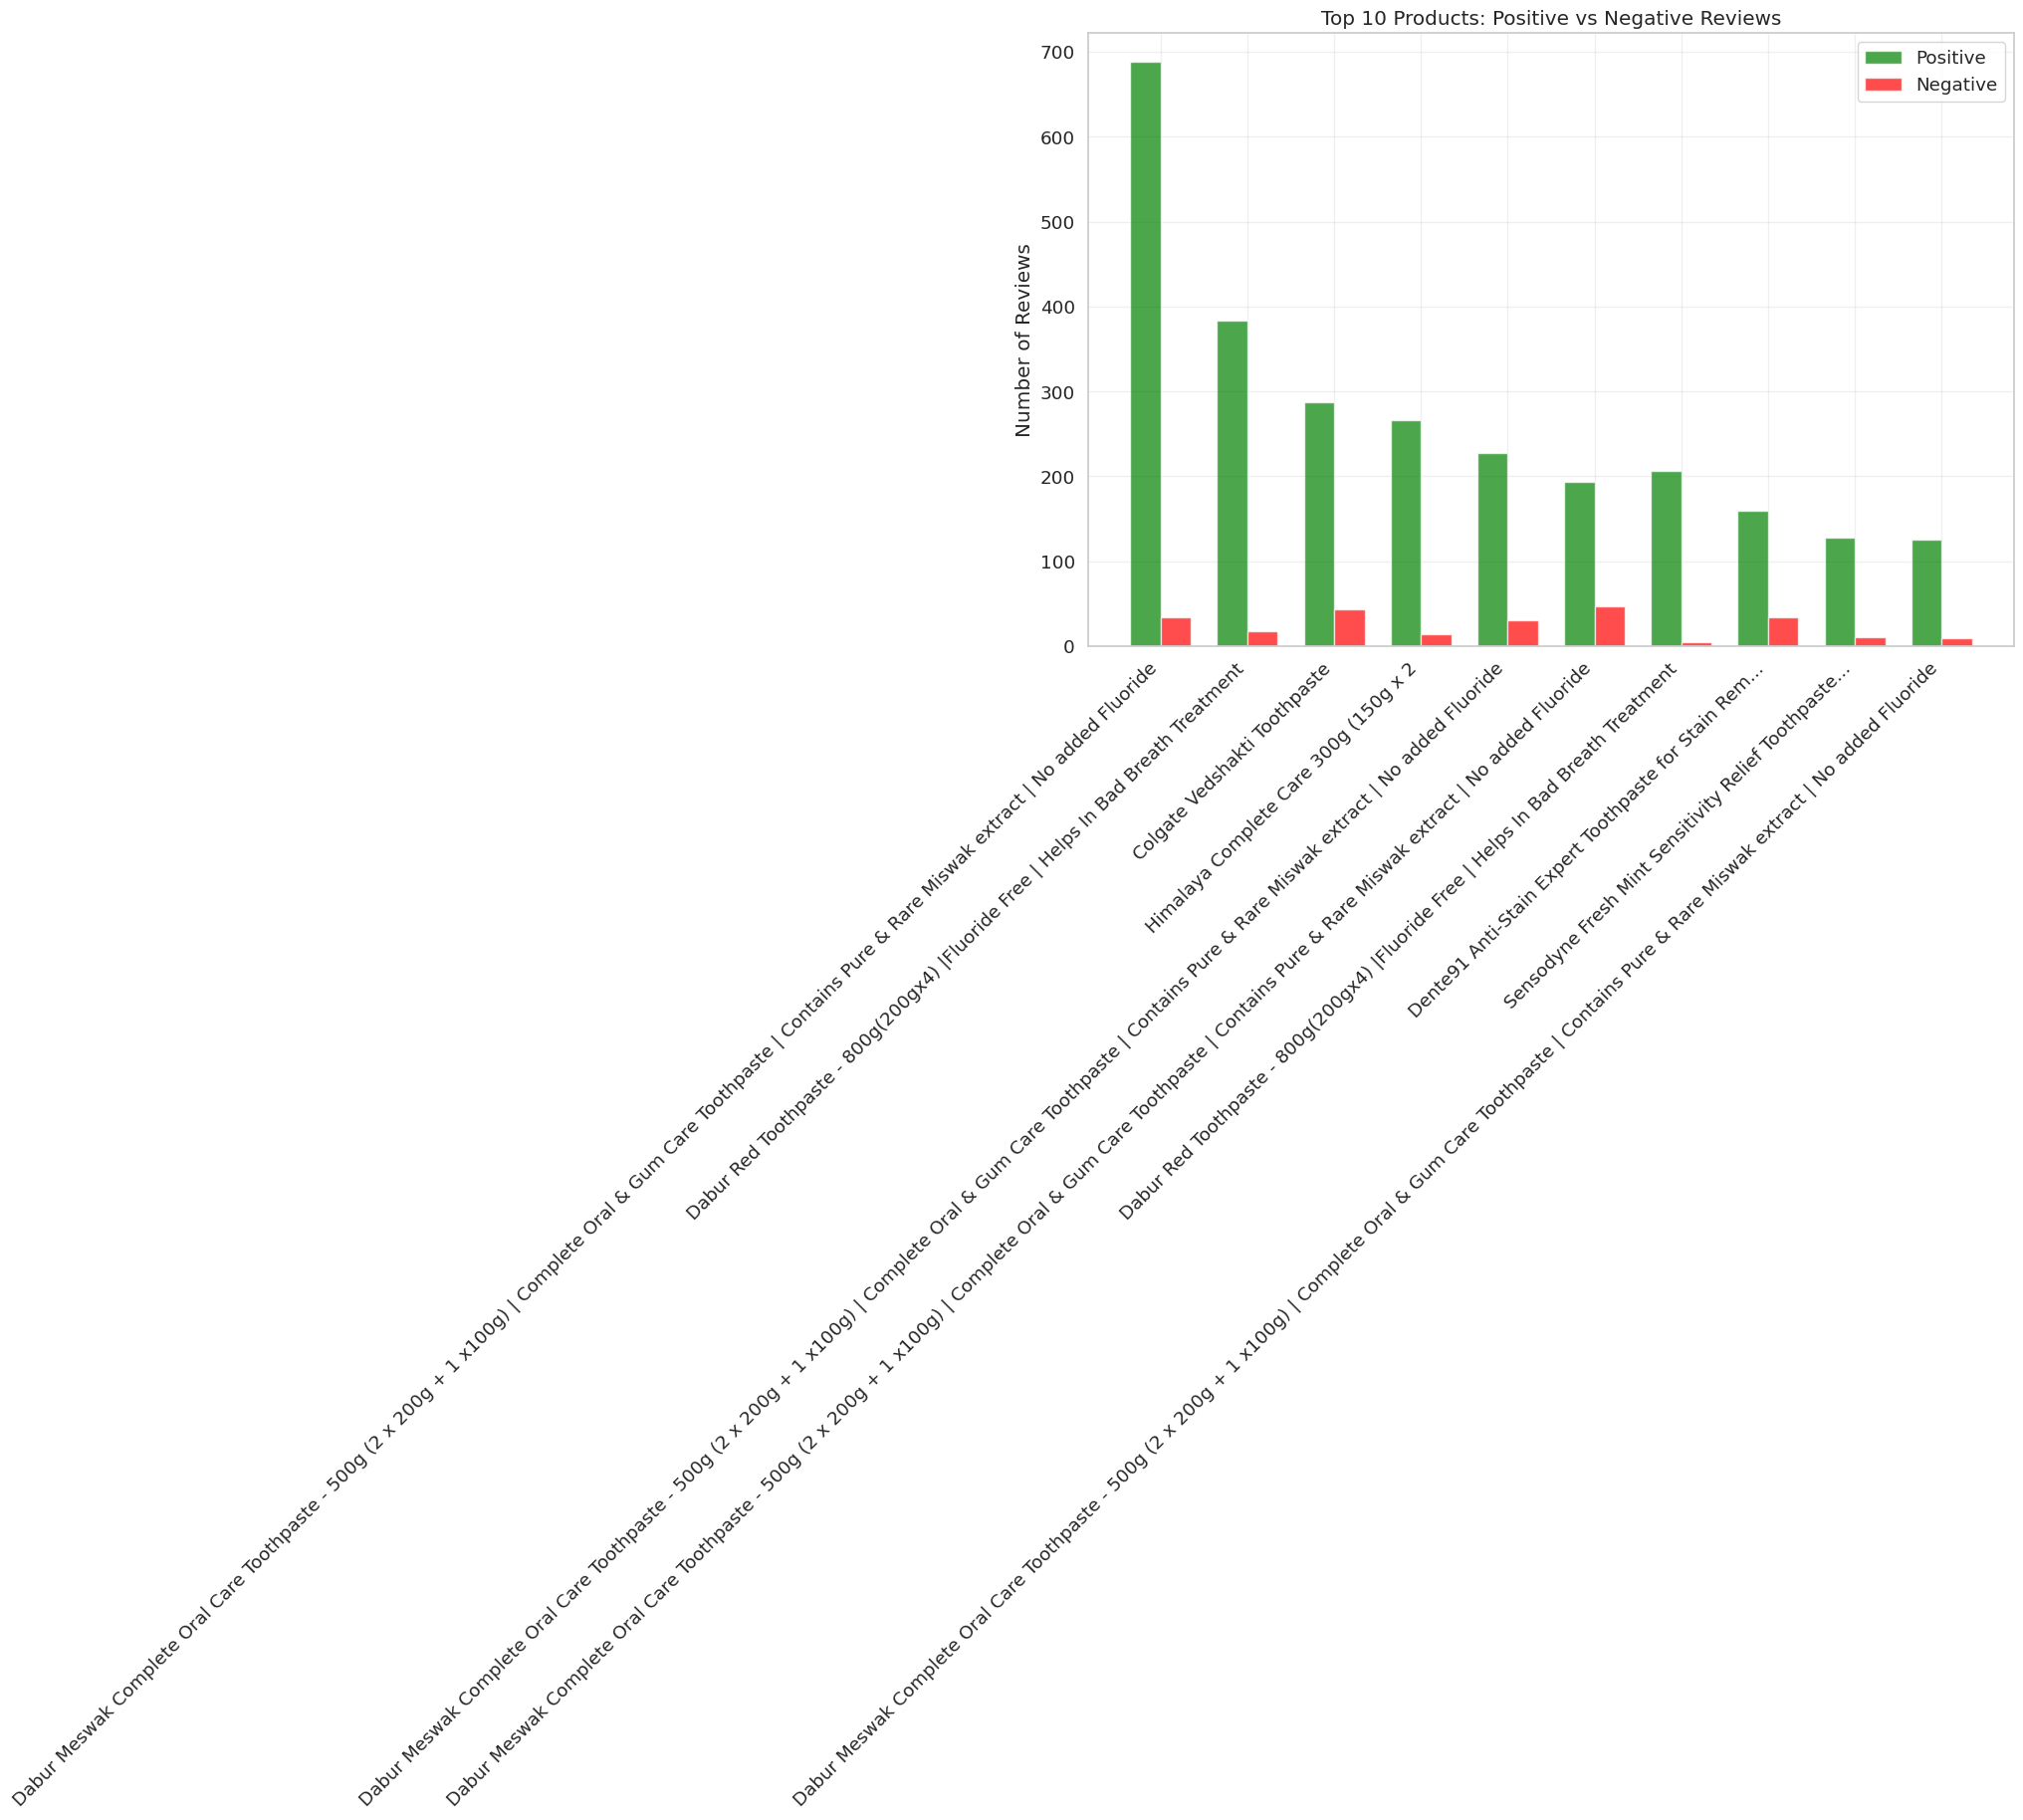

In [ ]:
plt.figure(figsize=(12, 8))

# Sort the dataframe by the number of total reviews in descending order and take the top 10 entries
df_sorted = df.sort_values('total_reviews', ascending=False).head(10)

# Define the width of the bars in the bar charts
width = 0.35

# Create an array of x positions for the bars
x = np.arange(len(df_sorted))

# Plot the number of positive reviews as green bars
plt.bar(x - width/2, df_sorted['positive_review'], width, label='Positive', color='green', alpha=0.7)

# Plot the number of negative reviews as red bars next to the positive bars
plt.bar(x + width/2, df_sorted['negative_review'], width, label='Negative', color='red', alpha=0.7)
plt.ylabel('Number of Reviews')
plt.title('Top 10 Products: Positive vs Negative Reviews')

# Set the x-axis tick labels to the short names of the products, rotate them 45 degrees, and align them to the right
plt.xticks(x, df_sorted['short_name'], rotation=45, ha='right')

plt.legend()
plt.grid(True, alpha=0.3)

# Adjust the layout to prevent clipping of the tick labels
plt.tight_layout()
plt.savefig('positive_negative_comparison.png')
plt.show()

In [ ]:
print("\n=== FEATURE-BASED SENTIMENT ANALYSIS ===")

# Extract key features from the dataframe and handle any missing values by filling them with an empty string
df['key_features'] = df['key_features'].fillna('')

# Initialize a set to store unique features found in the 'key_features' column
all_features = set()

# Loop through each entry in the 'key_features' column
for features in df['key_features']:
    # If the features are not empty, add them to the set of unique features
    if features:
        all_features.add(features)

# Print the number of unique features identified
print(f"\nUnique features identified: {len(all_features)}")
# Print a sample of the first five unique features
print("Sample features:", list(all_features)[:5])

## Output Explanation :
#It indicates that there are 60 unique features identified across the dataset being analyzed.
#These features likely represent different aspects or characteristics of products that are important to consumers.
#The sample features listed—'Combination', 'Build quality', 'Oral health', 'Appearance', 'Cleaning effectiveness'—are examples of these unique features.
#They give an idea of what kind of attributes people might consider when evaluating products, such as how well they are constructed,
#their impact on oral health, how they look, and how effectively they clean.


=== FEATURE-BASED SENTIMENT ANALYSIS ===

Unique features identified: 60
Sample features: ['Combination', 'Build quality', 'Oral health', 'Appearance', 'Cleaning effectiveness']


In [ ]:
#The purpose of this code is to analyze the sentiment associated with each unique feature of products in the dataset.
# Initialize an empty dictionary to store sentiment analysis results by feature
feature_sentiment = {}

# Loop through each unique feature identified earlier
for feature in all_features:
    # Filter the dataframe to get only the rows where the 'key_features' column matches the current feature
    feature_data = df[df['key_features'] == feature]

    # Check if there is any data for the current feature (i.e., the filtered dataframe is not empty)
    if not feature_data.empty:
        # Calculate the average sentiment score for the current feature
        avg_sentiment = feature_data['sentiment_score'].mean()

        # Count the number of entries for the current feature
        count = len(feature_data)

        # Calculate the average sentiment ratio (positive sentiment) for the current feature
        pos_ratio = feature_data['sentiment_ratio'].mean()

        # Store the results in the feature_sentiment dictionary
        feature_sentiment[feature] = {
            'avg_sentiment': avg_sentiment,  # Average sentiment score
            'count': count,  # Number of entries
            'pos_ratio': pos_ratio  # Average positive sentiment ratio
        }

In [ ]:
#The purpose of these lines of code is to organize the sentiment analysis results by feature into a structured format that is easier to analyze and interpret
# Convert the dictionary of feature sentiments into a pandas DataFrame for easier analysis and manipulation
feature_df = pd.DataFrame.from_dict(feature_sentiment, orient='index')

# Reset the index of the DataFrame to make the feature names a regular column instead of the index
feature_df = feature_df.reset_index()

# Rename the 'index' column to 'feature' for clarity
feature_df = feature_df.rename(columns={'index': 'feature'})

# Sort the DataFrame by the 'avg_sentiment' column in descending order to show features with the highest average sentiment scores first
feature_df = feature_df.sort_values('avg_sentiment', ascending=False)

# Print the resulting DataFrame to display the sentiment analysis results by feature
print("\nSentiment by feature:")
print(feature_df)



Sentiment by feature:
                     feature  avg_sentiment  count  pos_ratio
0                Combination       1.000000      1   1.000000
2                Oral health       1.000000      2   1.000000
3                 Appearance       1.000000      1   1.000000
5                  Feel good       1.000000      1   1.000000
11             Kids friendly       1.000000      1   1.000000
7             Copper content       1.000000      1   1.000000
25               Kids safety       1.000000      1   1.000000
22                     Brand       1.000000      1   1.000000
21       Tooth paste quality       1.000000      2   1.000000
15          Breath freshness       1.000000      7   1.000000
13              Satisfaction       1.000000      1   1.000000
12         Toothpaste safety       1.000000      2   1.000000
44         Mouth cleanliness       1.000000      1   1.000000
47               Cleanliness       1.000000      1   1.000000
49          Cleaning ability       1.000000    

<ipython-input-20-61aa50c2c75e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature', y='avg_sentiment', data=feature_df, palette=list(colors))


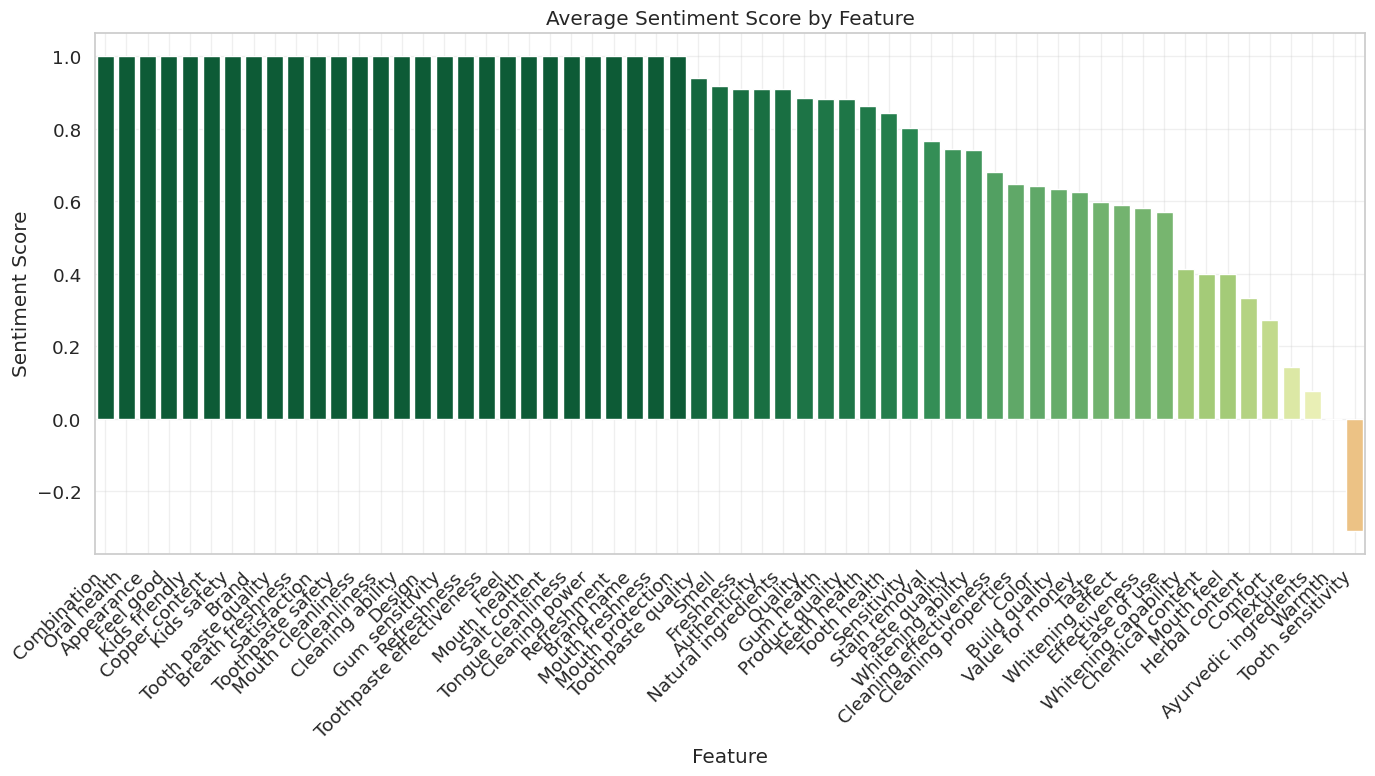

In [ ]:
# Create a new figure with a specified size
plt.figure(figsize=(14, 8))

# Define a color palette based on the 'pos_ratio' (positive sentiment ratio) of each feature
colors = plt.cm.RdYlGn(feature_df['pos_ratio'])

# Create a bar plot using seaborn, with 'feature' on the x-axis and 'avg_sentiment' on the y-axis
# Use the defined color palette to color the bars based on the positive sentiment ratio
sns.barplot(x='feature', y='avg_sentiment', data=feature_df, palette=list(colors))

# Set the title of the chart to 'Average Sentiment Score by Feature'
plt.title('Average Sentiment Score by Feature')

# Label the x-axis as 'Feature' and the y-axis as 'Sentiment Score'
plt.xlabel('Feature')
plt.ylabel('Sentiment Score')

# Rotate the x-axis tick labels 45 degrees and align them to the right for better readability
plt.xticks(rotation=45, ha='right')

# Add a grid to the chart with a specified transparency
plt.grid(True, alpha=0.3)

# Adjust the layout to prevent clipping of the tick labels
plt.tight_layout()

# Save the plot as a PNG file named 'feature_sentiment.png'
plt.savefig('feature_sentiment.png')

# Display the plot
plt.show()

# Output Explanation :
#This graph portrays the average sentiment scores for various features associated with products.
#Each bar represents a different feature, and the height of the bar indicates the average sentiment score, which ranges from negative to positive.
#The features are listed on the x-axis, while the y-axis shows the sentiment score.
#A score of 1.0 represents the most positive sentiment, while a score of 0 indicates a neutral sentiment.
#The graph shows that most features have high positive sentiment scores, close to 1.0, indicating that customers generally have a favorable view of these aspects.
#However, as we move further right on the graph, the sentiment scores decrease, suggesting that those features are perceived less positively.
#The color gradient from dark green to light beige visually reinforces this transition from highly positive to less positive sentiment.
#This type of analysis helps businesses identify which features are most appreciated by customers and which might need improvement.

In [ ]:
#The purpose of this code is to analyze customer sentiment towards products based on their price ranges
print("\n=== PRICE SENTIMENT ANALYSIS ===")

# Create price bins to categorize products based on their price ranges
df['price_bin'] = pd.cut(df['price'], bins=[0, 200, 300, 400, 500],
                          labels=['<200', '200-300', '300-400', '400-500'])

# Group the data by the price bins and calculate aggregate statistics for each bin
price_sentiment = df.groupby('price_bin').agg({
    'sentiment_ratio': 'mean',  # Calculate the average sentiment ratio
    'sentiment_score': 'mean',  # Calculate the average sentiment score
    'count': 'sum',  # Calculate the total count of products in each bin
    'price': 'mean'  # Calculate the average price in each bin
}).reset_index()  # Reset the index to make 'price_bin' a column again

# Print the resulting DataFrame to display the sentiment analysis results by price range
print("\nSentiment by price range:")
print(price_sentiment)





# Output :
# The output from the price sentiment analysis provides insights into how customer sentiment varies across different price brackets.
#The data is organized into four distinct price ranges: less than 200, 200-300, 300-400, and 400-500. For each price range, the analysis calculates
#the sentiment ratio, which is the average proportion of positive reviews, the sentiment score, which quantifies the overall sentiment expressed in reviews,
# the count of products within each range, and the average price of those products.

# The findings indicate that as the price increases, so does the sentiment ratio and sentiment score, suggesting that customers tend to express more positive sentiments
#towards higher-priced products.
#Products in the 300-400 and 400-500 price ranges have the highest sentiment ratios and scores, indicating a strong positive reception among customers.
#However, it's also noted that the number of products in these higher price ranges is significantly lower compared to the lower price brackets.

#This analysis helps businesses understand the relationship between product pricing and customer satisfaction,
# which can inform pricing strategies and product positioning. It suggests that while higher prices might be associated with higher satisfaction,
#businesses also need to consider the volume of products they can sell at those prices.


=== PRICE SENTIMENT ANALYSIS ===

Sentiment by price range:
  price_bin  sentiment_ratio  sentiment_score  count       price
0      <200         0.844418         0.688837   3531  147.524272
1   200-300         0.903801         0.807601   3288  243.736842
2   300-400         0.961444         0.922888   1149  347.923077
3   400-500         0.961982         0.923963    171  456.000000


<ipython-input-21-5f838e212030>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_sentiment = df.groupby('price_bin').agg({


<ipython-input-22-610e2af96a4e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price_bin', y='sentiment_score', data=price_sentiment, palette='viridis')


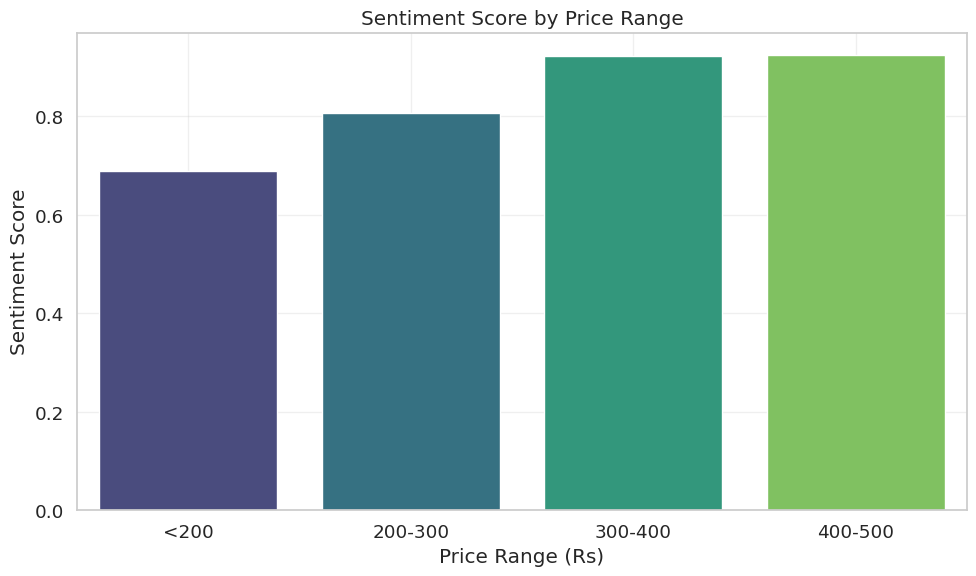

In [ ]:
# Plot sentiment by price bin
plt.figure(figsize=(10, 6))
sns.barplot(x='price_bin', y='sentiment_score', data=price_sentiment, palette='viridis')
plt.title('Sentiment Score by Price Range')
plt.xlabel('Price Range (Rs)')
plt.ylabel('Sentiment Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('price_range_sentiment.png')
plt.show()

In [ ]:
# Print a header to indicate the start of the review text analysis section
print("\n=== REVIEW TEXT ANALYSIS ===")

# Combine all review texts for analysis
# Define a function to clean the text data
def clean_text(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Remove punctuation and convert all characters to lowercase to standardize the text
        text = text.lower()
        # Use a regular expression to remove any characters that are not words or whitespace
        text = re.sub(r'[^\w\s]', '', text)
        # Return the cleaned text
        return text
    # If the input is not a string, return an empty string
    return ""


=== REVIEW TEXT ANALYSIS ===


In [ ]:
# Create a new column 'all_reviews' that combines all review texts into a single string for each product
df['all_reviews'] = df['detailed_review_text'] + ' ' + df['review_2'].fillna('') + ' ' + \
                   df['review_3'].fillna('') + ' ' + df['review_4'].fillna('')

# Apply the clean_text function to the 'all_reviews' column to clean the combined review text
df['all_reviews'] = df['all_reviews'].apply(clean_text)

# Filter the dataframe to get only the rows where the sentiment score is positive (greater than 0.5)
positive_products = df[df['sentiment_score'] > 0.5]

# Filter the dataframe to get only the rows where the sentiment score is negative (less than 0)
negative_products = df[df['sentiment_score'] < 0]

# Combine all the positive review texts into a single string
all_positive_text = ' '.join(positive_products['all_reviews'])

# Combine all the negative review texts into a single string
all_negative_text = ' '.join(negative_products['all_reviews'])

In [ ]:
# Define a function to generate a word cloud from a given text
def generate_wordcloud(text, title):
    # Create a WordCloud object with specified parameters
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3, contour_color='steelblue').generate(text)

    # Create a new figure with a specified size
    plt.figure(figsize=(10, 5))

    # Display the word cloud image
    plt.imshow(wordcloud, interpolation='bilinear')

    # Turn off the axis for a cleaner look
    plt.axis('off')

    # Set the title of the plot
    plt.title(title)

    # Adjust the layout to prevent clipping of the title
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

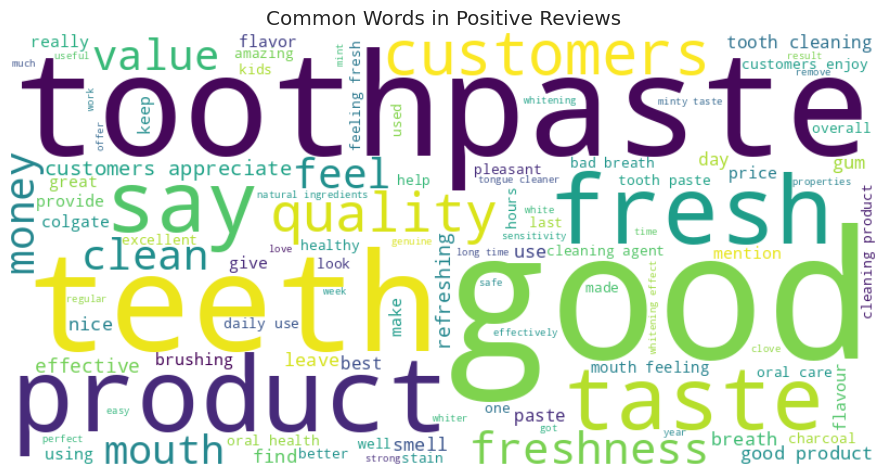

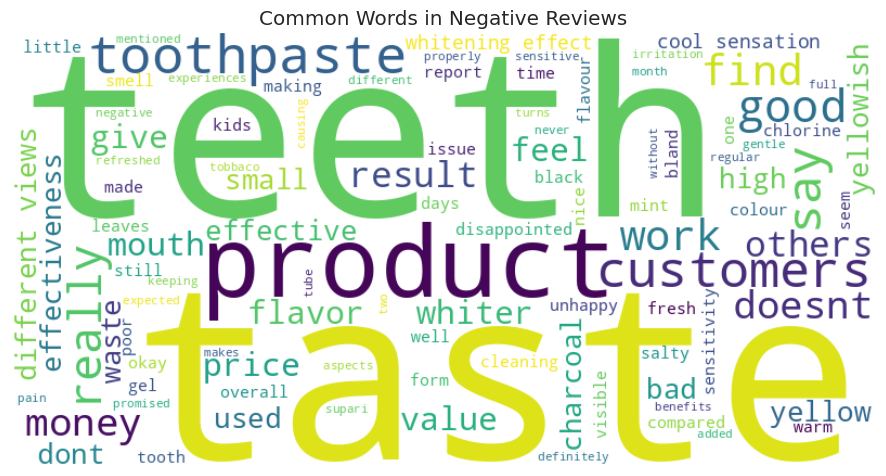

In [ ]:
# Generate word clouds
generate_wordcloud(all_positive_text, 'Common Words in Positive Reviews')
generate_wordcloud(all_negative_text, 'Common Words in Negative Reviews')

In [ ]:
# Define a function to perform a simplified term frequency analysis without using NLTK
def get_top_words(text, n=20):
    # Define a basic set of stopwords to exclude from the analysis
    stopwords = {'and', 'the', 'is', 'in', 'it', 'to', 'that', 'of', 'for', 'with', 'this', 'on', 'are', 'as', 'at', 'be', 'by', 'from', 'has', 'have', 'i', 'my', 'not', 'they', 'was', 'were', 'will', 'a', 'an', 'but', 'or', 'if', 'because', 'what', 'which', 'when', 'where', 'who', 'how', 'am', 'me', 'so', 'us', 'you', 'your', 'he', 'she', 'its'}

    # Split the text into words and count the frequency of each word, excluding stopwords and short words
    words = text.split()
    word_counts = Counter([word for word in words if word not in stopwords and len(word) > 2])
    # Return the top n most common words and their frequencies
    return word_counts.most_common(n)

# Call the function to get the top words from the combined positive review texts
pos_top_words = get_top_words(all_positive_text)

# Call the function to get the top words from the combined negative review texts
neg_top_words = get_top_words(all_negative_text)

In [ ]:
print("\nTop words in positive reviews:")
# Loop through the list of top words and their counts in positive reviews
for word, count in pos_top_words:
    # Print each word along with its frequency count
    print(f"{word}: {count}")

# Print a header to indicate the start of the top words in negative reviews section
print("\nTop words in negative reviews:")
# Loop through the list of top words and their counts in negative reviews
for word, count in neg_top_words:
    # Print each word along with its frequency count
    print(f"{word}: {count}")


Top words in positive reviews:
good: 323
product: 195
teeth: 194
customers: 189
toothpaste: 161
fresh: 146
like: 118
taste: 112
quality: 108
say: 101
very: 98
freshness: 96
mouth: 93
value: 82
breath: 77
money: 77
cleaning: 75
appreciate: 72
tooth: 71
use: 68

Top words in negative reviews:
customers: 10
taste: 10
like: 10
teeth: 9
toothpaste: 9
say: 8
product: 8
really: 8
good: 8
find: 7
very: 7
some: 6
doesnt: 6
money: 6
others: 5
work: 5
also: 5
their: 5
different: 4
results: 4


In [ ]:
# 8. Complex Sentiment Analysis - Create a Custom Sentiment Lexicon
# ---------------------------------------------------------------

print("\n=== ADVANCED SENTIMENT ANALYSIS ===")

# Create a simple sentiment lexicon (you could expand this)
# Define a list of words with positive sentiment
positive_words = ['good', 'great', 'excellent', 'best', 'amazing', 'love', 'nice', 'perfect',
                 'fresh', 'clean', 'whitening', 'refreshing', 'effective', 'quality', 'worth',
                 'recommended', 'value', 'better', 'like', 'pleasant', 'bright', 'whitens']

# Define a list of words with negative sentiment
negative_words = ['bad', 'worst', 'terrible', 'poor', 'waste', 'expensive', 'not', 'never',
                 'disappointing', 'disappointed', 'harsh', 'sensitive', 'avoid', 'bitter',
                 'chemical', 'tasteless', 'expensive', 'yellowish', 'tastes', 'price', 'ordinary']



=== ADVANCED SENTIMENT ANALYSIS ===


In [ ]:
# Define a function to calculate a custom sentiment score based on a sentiment lexicon
def custom_sentiment_score(text):
    # Check if the input is a string, if not return a sentiment score of 0
    if not isinstance(text, str):
        return 0

    # Convert the text to lowercase to make the analysis case-insensitive
    text = text.lower()
    # Use regular expression to find all words in the text
    words = re.findall(r'\b\w+\b', text)

    # Initialize counters for positive and negative words
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)

    # Define a list of negation words to check for negated sentiments
    negations = ['not', 'no', 'never', "doesn't", "don't", "didn't", "wouldn't", "couldn't", "shouldn't"]
    # Loop through each word in the text
    for i, word in enumerate(words):
        # If the word is a negation, check the next word to see if it's positive or negative
        if word in negations and i+1 < len(words):
            # If the next word is positive, decrease the positive count and increase the negative count
            if words[i+1] in positive_words:
                pos_count -= 1
                neg_count += 1
            # If the next word is negative, decrease the negative count and increase the positive count
            elif words[i+1] in negative_words:
                neg_count -= 1
                pos_count += 1

    # Calculate the total count of words that have sentiment (positive or negative)
    total = pos_count + neg_count
    # If there are no sentiment words, return a sentiment score of 0
    if total == 0:
        return 0
    # Return a normalized sentiment score (the difference between positive and negative counts divided by the total count)
    return (pos_count - neg_count) / total

In [ ]:
# Apply the custom sentiment score function to each review text in the 'all_reviews' column
df['custom_sentiment'] = df['all_reviews'].apply(custom_sentiment_score)

# Print a header to indicate the start of the custom sentiment score examples section
print("\nCustom sentiment score examples:")
# Select the first 10 entries from the dataframe to display examples of reviews with their custom sentiment scores
sample_reviews = df[['short_name', 'all_reviews', 'custom_sentiment', 'sentiment_score']].head(10)
# Print the selected sample reviews with their corresponding scores
print(sample_reviews)


# Output Explanation:
# This output provides a snapshot of a custom sentiment analysis performed on toothpaste product reviews.
# The dataset includes product names, the combined text of multiple reviews, a custom sentiment score calculated based on a list of positive and negative words,
# and the original sentiment score.
# The custom sentiment scores range from 0 to 1, with higher values indicating more positive sentiment.
# The analysis shows that reviews highlighting the toothpaste's whitening effect and quality received high positive scores,
#while a more neutral statement about value for money received a lower score.
#This information can help businesses understand customer preferences and areas for product improvement.

# In short, the output shows how a custom sentiment analysis function evaluates toothpaste reviews,
#identifying positive feedback on whitening effects and quality, while also flagging neutral comments on value for money.


Custom sentiment score examples:
                                          short_name  \
0  Colgate Visible White Purple Toothpaste For Te...   
1  Colgate Visible White Purple Toothpaste For Te...   
2  Colgate Visible White Purple Toothpaste For Te...   
3  Colgate Visible White Purple Toothpaste For Te...   
4  Colgate Visible White Purple Toothpaste For Te...   
5  Colgate Visible White Purple Toothpaste For Te...   
6  Colgate Visible White Purple Toothpaste For Te...   
7  Colgate Visible White Purple Toothpaste For Te...   
8                   Colgate Visible White Toothpaste   
9                   Colgate Visible White Toothpaste   

                                         all_reviews  custom_sentiment  \
0   customers like the whitening effect of the to...          1.000000   
1   customers appreciate the quality of the tooth...          1.000000   
2   customers like the toothpastes effectiveness ...          0.000000   
3   customers like the color of the tooth cleanin... 

In [ ]:
# 9. Product Recommendation based on Sentiment
# -------------------------------------------
#The purpose of this code is to identify and recommend the top 5 products based on their overall sentiment scores.
print("\n=== PRODUCT RECOMMENDATIONS ===")

# Sort the dataframe based on the 'sentiment_score' column in descending order to find the best products overall
best_overall = df.sort_values('sentiment_score', ascending=False).head(5)

# Print a header for the top 5 products by overall sentiment
print("\nTop 5 Products by Overall Sentiment:")
# Loop through the top 5 products and print their short name, sentiment score, and price
for i, (_, row) in enumerate(best_overall.iterrows(), 1):
    print(f"{i}. {row['short_name']} - Score: {row['sentiment_score']:.2f}, Price: Rs.{row['price']}")



=== PRODUCT RECOMMENDATIONS ===

Top 5 Products by Overall Sentiment:
1. Colgate Visible White Purple Toothpaste For Teeth Whitening - Score: 1.00, Price: Rs.278
2. Colgate Visible White Purple Toothpaste For Teeth Whitening - Score: 1.00, Price: Rs.278
3. Colgate Visible White Purple Toothpaste For Teeth Whitening - Score: 1.00, Price: Rs.278
4. Colgate Visible White Toothpaste - Score: 1.00, Price: Rs.243
5. Colgate Visible White Toothpaste - Score: 1.00, Price: Rs.243


In [ ]:
# The purpose of this code is to identify and recommend the top 5 products that offer the best value for money based on their sentiment scores relative to their prices.
# Calculate a new column 'value_score' which represents the value for money based on sentiment score and price
df['value_score'] = df['sentiment_score'] / df['price'] * 100  # Scale for readability

# Sort the dataframe based on the 'value_score' column in descending order to find the best value for money products
best_value = df.sort_values('value_score', ascending=False).head(5)

# Print a header for the top 5 products by value for money
print("\nTop 5 Products by Value for Money:")
# Loop through the top 5 products and print their short name, value score, and price
for i, (_, row) in enumerate(best_value.iterrows(), 1):
    print(f"{i}. {row['short_name']} - Value Score: {row['value_score']:.2f}, Price: Rs.{row['price']}")


Top 5 Products by Value for Money:
1. Colgate Vedshakti Toothpaste - Value Score: 1.25, Price: Rs.80
2. Colgate Vedshakti Toothpaste - Value Score: 1.25, Price: Rs.80
3. Colgate Active Salt Neem Toothpaste - Value Score: 1.14, Price: Rs.88
4. Colgate Active Salt Neem Toothpaste - Value Score: 1.14, Price: Rs.88
5. Colgate Active Salt Neem Toothpaste - Value Score: 1.14, Price: Rs.88


In [ ]:
# The purpose of this code is to provide product recommendations based on specific features that customers care about.
#It identifies the best product for each of the top 5 features with the highest average sentiment scores.
# Print a header to indicate the start of the recommendations by feature section
print("\nBest Products by Feature:")

# Loop through the top 5 features based on average sentiment score
for feature in feature_df['feature'].head(5):
    # Find the product with the best sentiment score for the current feature
    best_for_feature = df[df['key_features'] == feature].sort_values('sentiment_score', ascending=False).head(1)
    # Check if there is at least one product for the current feature
    if not best_for_feature.empty:
        # Get the first (and only) product in the result
        product = best_for_feature.iloc[0]
        # Print the feature name, the recommended product's short name, and its sentiment score
        print(f"For {feature}: {product['short_name']} - Score: {product['sentiment_score']:.2f}")



Best Products by Feature:
For Combination: Colgate MaxFresh Toothpaste - Score: 1.00
For Oral health: Close Up Toothpaste | Long lasting 18 Hours Of Fre... - Score: 1.00
For Appearance: Colgate Visible White Toothpaste - Score: 1.00
For Feel good: Colgate Vedshakti Toothpaste - Score: 1.00
For Kids friendly: Colgate Toothpaste for Kids (6-9 years) - Score: 1.00


In [ ]:
# 10. Summary and Conclusions
# --------------------------
print("\n=== SUMMARY AND CONCLUSIONS ===")

# Calculate the overall average sentiment score across all products
avg_sentiment = df['sentiment_score'].mean()

# Identify the product with the highest sentiment score
best_product = df.loc[df['sentiment_score'].idxmax()]['short_name']

# Identify the product with the lowest sentiment score
worst_product = df.loc[df['sentiment_score'].idxmin()]['short_name']

# Identify the feature with the highest average sentiment score
best_feature = feature_df.iloc[0]['feature']

# Identify the feature with the lowest average sentiment score
worst_feature = feature_df.iloc[-1]['feature']

print(f"\nOverall market sentiment: {avg_sentiment:.2f}")
print(f"Best performing product: {best_product}")
print(f"Worst performing product: {worst_product}")
print(f"Most valued feature: {best_feature}")
print(f"Least valued feature: {worst_feature}")


=== SUMMARY AND CONCLUSIONS ===


In [ ]:
# Calculate the correlation between the price and sentiment score of products
corr = df['price'].corr(df['sentiment_score'])

# Print the correlation value formatted to two decimal places
print(f"\nCorrelation between price and sentiment: {corr:.2f}")

# Determine and print the nature of the correlation
if corr > 0.3:
    # If the correlation is greater than 0.3, there is a positive correlation
    print("There is a positive correlation - higher priced products tend to have better sentiment")
elif corr < -0.3:
    # If the correlation is less than -0.3, there is a negative correlation
    print("There is a negative correlation - lower priced products tend to have better sentiment")
else:
    # If the absolute value of the correlation is less than or equal to 0.3, there is no strong correlation
    print("There is no strong correlation between price and sentiment")


Correlation between price and sentiment: 0.23
There is no strong correlation between price and sentiment


In [ ]:
# 11. Sentiment Segmentation (Positive, Negative, Neutral)
# The purpose of this code is to add a new column to the dataframe that categorizes each product's sentiment score into one of three categories: 'Positive', 'Negative', or 'Neutral'.
print("\n=== SENTIMENT SEGMENTATION ===")

# Define a function to categorize sentiment scores into 'Positive', 'Negative', or 'Neutral'
def categorize_sentiment(score):
    # If the score is greater than 0.2, categorize it as 'Positive'
    if score > 0.2:
        return "Positive"
    # If the score is less than -0.2, categorize it as 'Negative'
    elif score < -0.2:
        return "Negative"
    # If the score is between -0.2 and 0.2, categorize it as 'Neutral'
    else:
        return "Neutral"

# Apply the categorize_sentiment function to the 'sentiment_score' column and store the results in a new column 'sentiment_category'
df['sentiment_category'] = df['sentiment_score'].apply(categorize_sentiment)


=== SENTIMENT SEGMENTATION ===


In [ ]:
# Count the number of products in each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# Print a header to indicate the product distribution by sentiment
print("\nProduct Distribution by Sentiment:")
# Print the count of products in each sentiment category
print(sentiment_counts)


Product Distribution by Sentiment:
sentiment_category
Positive    200
Neutral      17
Negative      6
Name: count, dtype: int64


In [ ]:
# Calculate the percentage distribution of products in each sentiment category
sentiment_percentage = sentiment_counts / len(df) * 100

# Print a header to indicate the start of the percentage distribution section
print("\nPercentage Distribution:")
# Loop through each sentiment category and its corresponding percentage
for category, percentage in sentiment_percentage.items():
    # Print the category and the percentage formatted to one decimal place
    print(f"{category}: {percentage:.1f}%")


Percentage Distribution:
Positive: 89.7%
Neutral: 7.6%
Negative: 2.7%


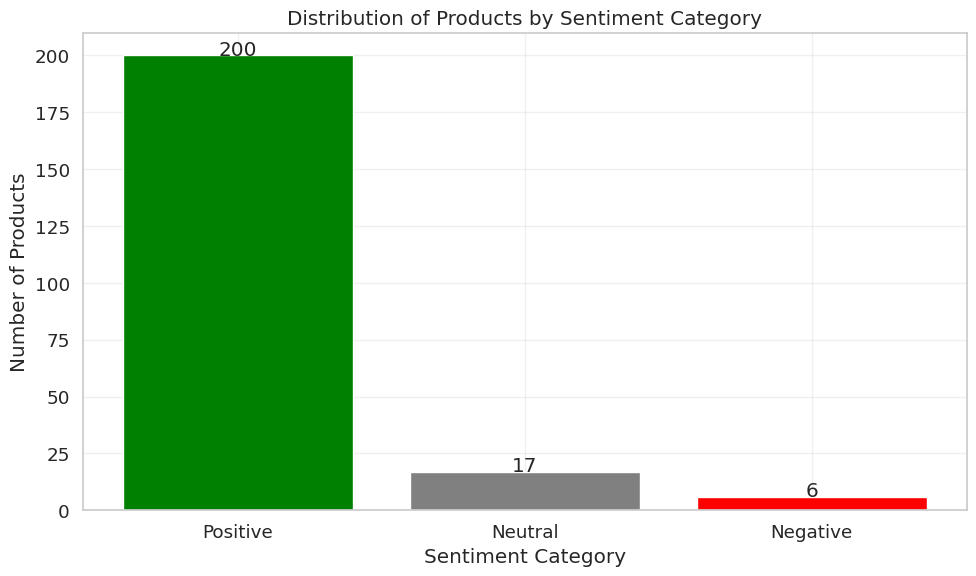

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
plt.bar(sentiment_counts.index, sentiment_counts.values, color=[colors[x] for x in sentiment_counts.index])
plt.title('Distribution of Products by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Products')
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

In [ ]:
# Group the dataframe by the 'sentiment_category' column and calculate the mean price for each category
price_by_sentiment = df.groupby('sentiment_category')['price'].mean().reset_index()

# Print a header to indicate the start of the average price by sentiment category section
print("\nAverage Price by Sentiment Category:")
# Print the resulting dataframe showing the average price for each sentiment category
print(price_by_sentiment)


# This analysis helps in understanding how sentiment categories are distributed across different price points.
#It can provide insights into whether higher-priced products tend to receive more positive sentiment,
#or if lower-priced products are more likely to be perceived as neutral or negative.
#This information can be valuable for pricing strategies, product positioning, and marketing efforts.


Average Price by Sentiment Category:
  sentiment_category       price
0           Negative  151.333333
1            Neutral  171.882353
2           Positive  239.765000


<ipython-input-45-ff8a2f3bd978>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sentiment_category', y='price', data=price_by_sentiment, palette=['gray', 'red', 'green'])


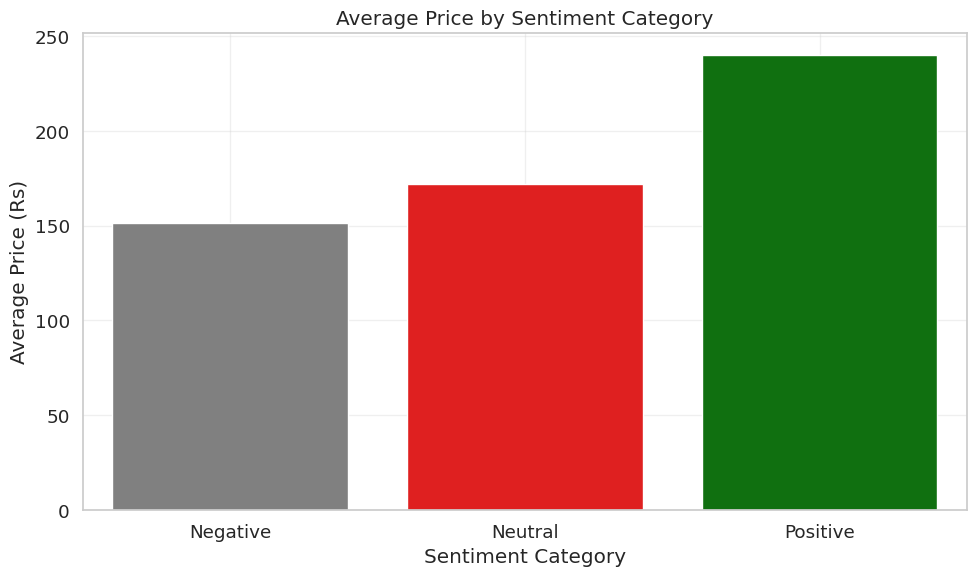

In [ ]:
# Plot average price by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment_category', y='price', data=price_by_sentiment, palette=['gray', 'red', 'green'])
plt.title('Average Price by Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Average Price (Rs)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('price_by_sentiment.png')
plt.show()

In [ ]:
# Create a cross-tabulation to show the count of each product type within each sentiment category
type_sentiment = pd.crosstab(df['product_type'], df['sentiment_category'])

# Calculate the percentage distribution within each product type by dividing by the row sums and multiplying by 100
type_sentiment_pct = type_sentiment.div(type_sentiment.sum(axis=1), axis=0) * 100

# Print a header to indicate the start of the product types by sentiment category section
print("\nProduct Types by Sentiment Category:")
# Print the cross-tabulation showing counts
print(type_sentiment)

# Print a header to indicate the start of the percentage distribution within each product type section
print("\nPercentage Distribution within Each Product Type:")
# Print the percentage distribution
print(type_sentiment_pct)

#The purpose of this code is to analyze the distribution of sentiment categories across different product types.


Product Types by Sentiment Category:
sentiment_category     Negative  Neutral  Positive
product_type                                      
Charcoal Clean                1        2        11
Lemon Fresh                   0        0         6
MaxFresh                      0        0        12
Other                         2       11       147
Total Advanced Health         0        0         8
Visible White                 0        0         7
Visible White O2              3        3         2
Visible White Purple          0        1         7

Percentage Distribution within Each Product Type:
sentiment_category      Negative    Neutral    Positive
product_type                                           
Charcoal Clean          7.142857  14.285714   78.571429
Lemon Fresh             0.000000   0.000000  100.000000
MaxFresh                0.000000   0.000000  100.000000
Other                   1.250000   6.875000   91.875000
Total Advanced Health   0.000000   0.000000  100.000000
Visible W

<Figure size 1400x800 with 0 Axes>

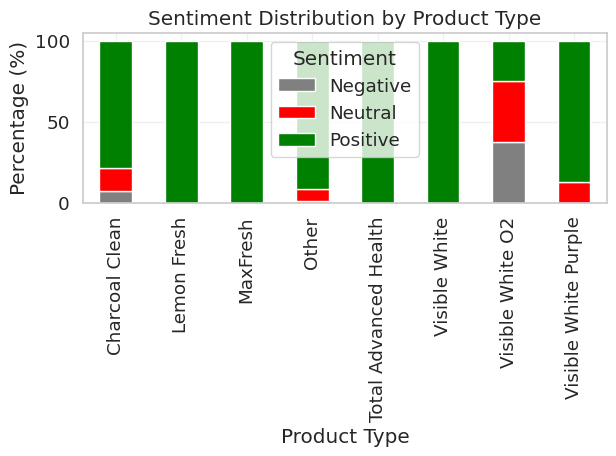

In [ ]:
# Plot product types by sentiment
plt.figure(figsize=(14, 8))
type_sentiment_pct.plot(kind='bar', stacked=True, color=['gray', 'red', 'green'])
plt.title('Sentiment Distribution by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Percentage (%)')
plt.legend(title='Sentiment')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_by_product_type.png')
plt.show()

In [ ]:
# 12. Basic Emotion Detection
# --------------------------
print("\n=== BASIC EMOTION DETECTION ===")

# Define emotion lexicons
emotion_lexicons = {
    'joy': ['happy', 'love', 'enjoy', 'pleased', 'excited', 'glad', 'satisfied', 'delighted',
            'great', 'amazing', 'perfect', 'excellent', 'wonderful', 'fantastic', 'awesome'],
    'trust': ['reliable', 'dependable', 'trustworthy', 'honest', 'authentic', 'genuine',
              'consistent', 'quality', 'effective', 'works', 'reliable', 'trusted'],
    'anticipation': ['expect', 'hope', 'look forward', 'waiting', 'anticipated', 'promising',
                    'soon', 'will', 'potential', 'future', 'hoping'],
    'surprise': ['surprised', 'unexpected', 'amazed', 'astonished', 'shocked', 'wow',
                'incredible', 'unbelievable', 'unprecedented', 'stunning'],
    'sadness': ['sad', 'disappointed', 'upset', 'unhappy', 'regret', 'waste', 'terrible',
               'poor', 'useless', 'waste', 'disappointing'],
    'disgust': ['disgusting', 'awful', 'gross', 'unpleasant', 'bad', 'horrible', 'yuck',
               'nasty', 'tasteless', 'ugly', 'harsh', 'bitter'],
    'anger': ['angry', 'frustrated', 'annoyed', 'irritated', 'mad', 'furious', 'outraged',
             'complaint', 'irritating', 'annoying', 'frustrating'],
    'fear': ['afraid', 'scared', 'worried', 'anxious', 'nervous', 'concerned', 'risky',
            'danger', 'harmful', 'scary', 'frightening']
}


=== BASIC EMOTION DETECTION ===


In [ ]:
# Define a function named 'detect_emotions' that takes a single parameter 'text'
def detect_emotions(text):
    # Check if the input 'text' is not a string. If it's not a string, return a dictionary
    # with all possible emotions set to a count of 0. 'emotion_lexicons' is assumed to be
    # a predefined dictionary mapping each emotion to its corresponding list of words.
    if not isinstance(text, str):
        return {emotion: 0 for emotion in emotion_lexicons}

    # Convert the input text to lowercase to make the emotion detection case-insensitive
    text = text.lower()

    # Use a regular expression to find all words in the text. The pattern '\b\w+\b' matches
    # word boundaries, ensuring that we capture whole words only.
    words = re.findall(r'\b\w+\b', text)

    # Initialize an empty dictionary to store the count of each emotion found in the text
    emotions = {}

    # Iterate over each emotion and its corresponding list of words (lexicon) in the
    # 'emotion_lexicons' dictionary
    for emotion, lexicon in emotion_lexicons.items():
        # Count how many words from the text are also present in the current emotion's lexicon
        count = sum(1 for word in words if word in lexicon)
        # Store the count in the 'emotions' dictionary with the corresponding emotion as the key
        emotions[emotion] = count

    # After processing all emotions, return the 'emotions' dictionary containing the count of each emotion
    return emotions

In [ ]:
# Print a message to indicate the start of the emotion analysis in reviews
print("Analyzing emotions in reviews...")

# Initialize an empty list to store the emotions detected in all reviews
all_emotions = []

# Iterate over each row in the dataframe
for _, row in df.iterrows():
    # Check if the 'all_reviews' column contains a string
    if isinstance(row['all_reviews'], str):
        # If it's a string, apply the detect_emotions function to the review text
        emotions = detect_emotions(row['all_reviews'])
        # Append the detected emotions to the all_emotions list
        all_emotions.append(emotions)
    else:
        # If it's not a string, append a dictionary with all emotions set to 0 to the all_emotions list
        all_emotions.append({emotion: 0 for emotion in emotion_lexicons})

Analyzing emotions in reviews...


In [ ]:
# Convert the list of emotion dictionaries into a pandas DataFrame for easier manipulation
emotion_df = pd.DataFrame(all_emotions)

# Add new columns to the main DataFrame for each emotion, using the corresponding values from the emotion_df
for emotion in emotion_lexicons:
    df[f'emotion_{emotion}'] = emotion_df[emotion]

In [ ]:
# Determine the dominant emotion for each product by finding the emotion with the highest count
df['dominant_emotion'] = emotion_df.idxmax(axis=1)

# Count the number of products for each dominant emotion
emotion_counts = df['dominant_emotion'].value_counts()
print("\nProduct Distribution by Dominant Emotion:")
print(emotion_counts)


Product Distribution by Dominant Emotion:
dominant_emotion
joy             107
trust            94
disgust           9
anticipation      4
sadness           4
fear              3
surprise          2
Name: count, dtype: int64



Average Emotion Scores Across All Products:
trust           1.121076
joy             0.681614
disgust         0.197309
anticipation    0.071749
sadness         0.071749
fear            0.058296
surprise        0.013453
anger           0.000000
dtype: float64


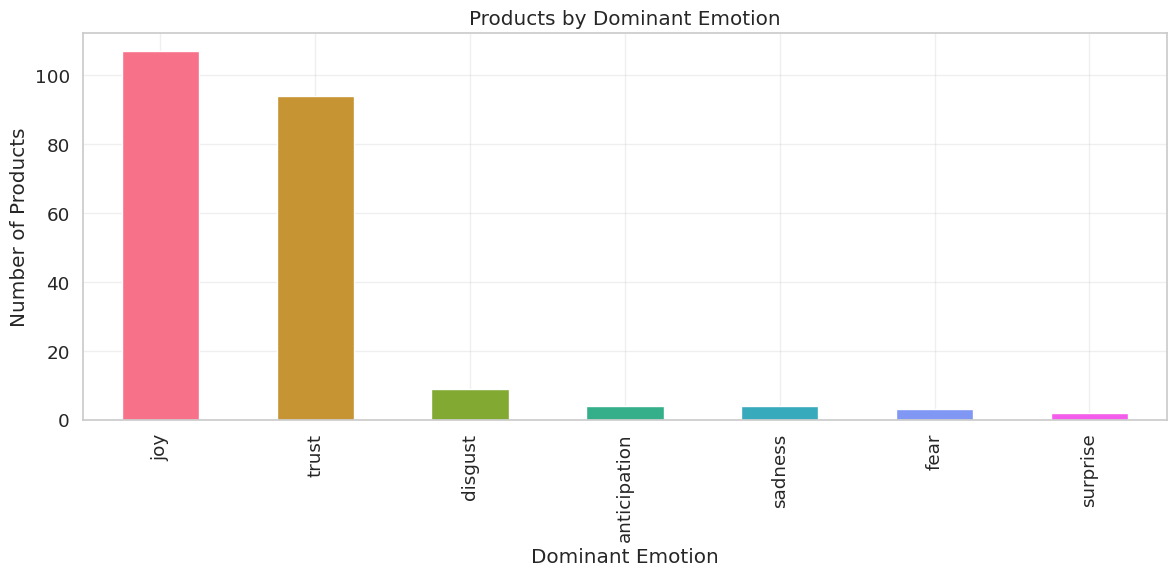

In [ ]:
# Calculate the average emotion scores across all products and sort them in descending order
avg_emotions = emotion_df.mean().sort_values(ascending=False)
print("\nAverage Emotion Scores Across All Products:")
print(avg_emotions)

# Plot the distribution of products by dominant emotion using a bar chart
plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color=sns.color_palette('husl', len(emotion_counts)))
plt.title('Products by Dominant Emotion')
plt.xlabel('Dominant Emotion')
plt.ylabel('Number of Products')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('emotion_distribution.png')
plt.show()


Relationship Between Sentiment and Emotions:
                    emotion_joy  emotion_trust  emotion_anticipation  \
sentiment_category                                                     
Negative               0.500000       0.333333              0.000000   
Neutral                0.294118       0.941176              0.117647   
Positive               0.720000       1.160000              0.070000   

                    emotion_surprise  emotion_sadness  emotion_disgust  \
sentiment_category                                                       
Negative                       0.000         1.500000         0.333333   
Neutral                        0.000         0.235294         0.294118   
Positive                       0.015         0.015000         0.185000   

                    emotion_anger  emotion_fear  
sentiment_category                               
Negative                      0.0      0.000000  
Neutral                       0.0      0.294118  
Positive              

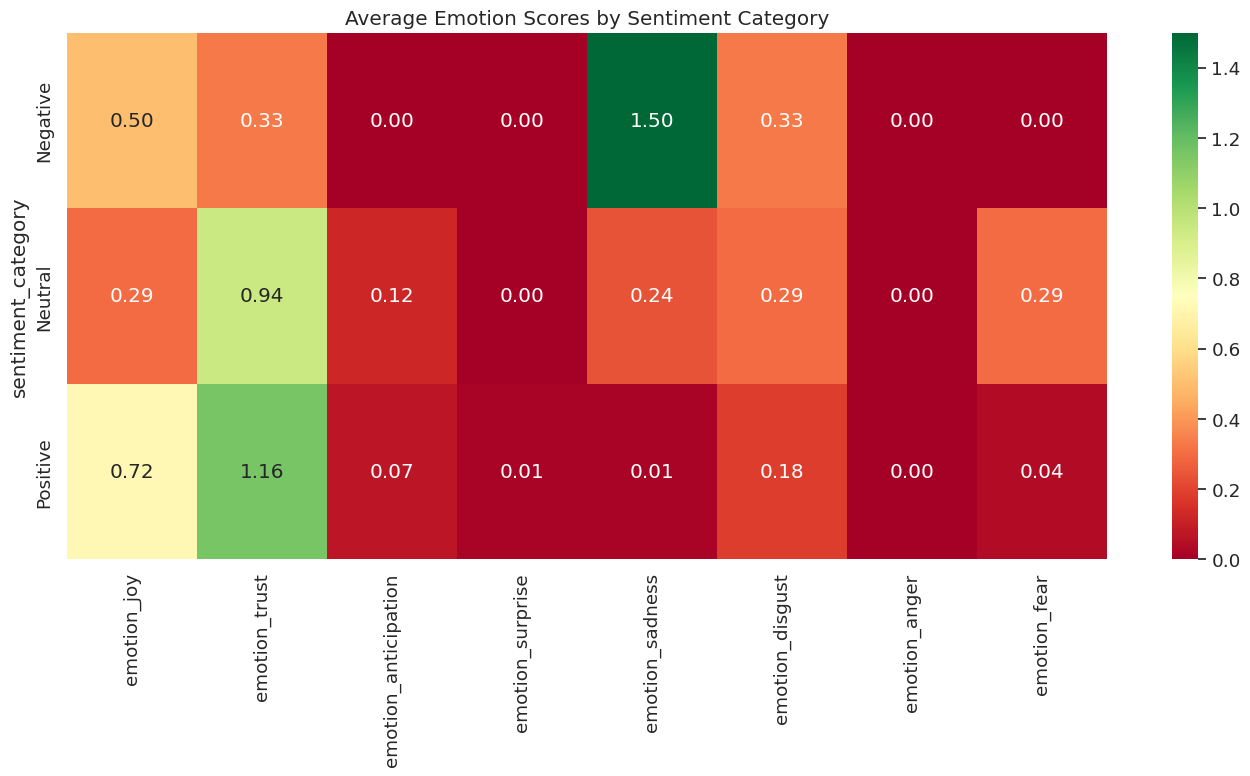

In [ ]:
# Print a header to indicate the start of the analysis of the relationship between sentiment and emotions
print("\nRelationship Between Sentiment and Emotions:")

# Group the dataframe by the 'sentiment_category' column to analyze sentiment categories
sentiment_emotion = df.groupby('sentiment_category')[['emotion_joy', 'emotion_trust', 'emotion_anticipation',
                                                     'emotion_surprise', 'emotion_sadness', 'emotion_disgust',
                                                     'emotion_anger', 'emotion_fear']].mean()

# Print the resulting dataframe showing the average emotion scores for each sentiment category
print(sentiment_emotion)

# Create a new figure with a specified size for the heatmap
plt.figure(figsize=(14, 8))

# Create a heatmap using seaborn to visualize the average emotion scores by sentiment category
# The 'annot=True' parameter displays the data values on the heatmap cells
# The 'fmt=".2f"' parameter formats the annotations to two decimal places
# The 'cmap="RdYlGn"' parameter sets the color map to a red-yellow-green scale
sns.heatmap(sentiment_emotion, annot=True, fmt=".2f", cmap="RdYlGn")

# Set the title of the heatmap to indicate its content
plt.title('Average Emotion Scores by Sentiment Category')

# Adjust the layout to prevent clipping of the title and axis labels
plt.tight_layout()

# Save the heatmap as a PNG file
plt.savefig('sentiment_emotion_relationship.png')

# Display the heatmap
plt.show()

In [ ]:
# 13. Sentiment Analysis of Features
# ---------------------------------
print("\n=== FEATURE-BASED SENTIMENT AND EMOTION ANALYSIS ===")

# Retrieve the top 5 features with the highest average sentiment scores from the feature_df DataFrame
top_features = feature_df.head(5)['feature'].tolist()

# Initialize a dictionary to store the sentiment analysis and emotion results for each feature
feature_reviews = {}

# Iterate through each top feature
for feature in top_features:
    # Filter the main DataFrame to get data related to the current feature
    feature_data = df[df['key_features'] == feature]
    # Check if there is any data for the current feature
    if not feature_data.empty:
        # Concatenate all review texts for the current feature into a single string
        all_text = ' '.join(feature_data['all_reviews'].dropna())

        # Detect emotions in the concatenated review text
        emotions = detect_emotions(all_text)

        # Store the sentiment score, emotions, and dominant emotion for the feature
        feature_reviews[feature] = {
            'sentiment_score': feature_data['sentiment_score'].mean(),  # Calculate the average sentiment score
            'emotions': emotions,  # Store the detected emotions
            'dominant_emotion': max(emotions.items(), key=lambda x: x[1])[0] if emotions else None  # Find the dominant emotion
        }


=== FEATURE-BASED SENTIMENT AND EMOTION ANALYSIS ===


In [ ]:
# Convert the feature_reviews dictionary to a DataFrame for easier display and analysis
feature_analysis = pd.DataFrame.from_dict(feature_reviews, orient='index')

# Print a header to indicate the sentiment and emotion analysis for top features
print("\nSentiment and Emotion Analysis for Top Features:")
# Print the DataFrame showing the sentiment score and dominant emotion for each feature
print(feature_analysis[['sentiment_score', 'dominant_emotion']])

# Initialize a dictionary to store the emotion scores for each feature
emotion_scores = {}
# Iterate over each feature and its data in the feature_reviews dictionary
for feature, data in feature_reviews.items():
    # Store the emotions detected for each feature in the emotion_scores dictionary
    emotion_scores[feature] = data['emotions']

# Convert the emotion_scores dictionary to a DataFrame for further analysis
emotion_feature_df = pd.DataFrame.from_dict(emotion_scores, orient='index')


Sentiment and Emotion Analysis for Top Features:
               sentiment_score dominant_emotion
Combination                1.0              joy
Oral health                1.0              joy
Appearance                 1.0              joy
Feel good                  1.0              joy
Kids friendly              1.0              joy
